<a href="https://colab.research.google.com/github/musicjae/recommender-system/blob/main/NCF/original_NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Import

In [3]:
!pip install wandb

     |████████████████████████████████| 1.8MB 14.5MB/s 
     |████████████████████████████████| 163kB 53.5MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 133kB 59.6MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=9466a69c9547a4cf6579d1e51ea19085a18a26fdbdd81362338bae4cb98673ce
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=71923b7ede36485c3b43fd21a195547a27ce8125d6121346c107701f0427a02a
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=5d3eba136da41e45dd3e07a9c588181d38bc241896

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge
from keras.utils import plot_model
from IPython.display import SVG
import matplotlib.pyplot as plt
from keras.backend import reshape as Reshape

import wandb
from wandb.keras import WandbCallback
from keras.callbacks import EarlyStopping

# 1 Data Load

In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/datasets/recommender_system/ml-1M/ratings.csv', header=0)

In [9]:
dataset.head(1)

,origin_uid,origin_iid,rating,timestamp,userId,itemId
0,1,1193,5,978300760,0,0


# 2 Preprocessing

### user

In [26]:
user_id = dataset['userId'].unique().tolist()
print(len(user_id))

6040


In [27]:
user2i = {u:i for i,u in enumerate(user_id)}
i2user = {i:u for i,u in enumerate(user_id)}

In [28]:
num_users = len(user2i) # user명에서 i로 변환된것을 사용

dataset 내의 모든 user에게 id 부여

In [29]:
dataset['user'] = dataset['userId'].map(user2i) # new row 'user'
print(dataset['user'].head(2))

0    0
1    0
Name: user, dtype: int64


#### movie

In [13]:
movie_id = dataset['itemId'].unique().tolist()

In [14]:
movie2i = {m:i for i,m in enumerate(movie_id)}
i2movie = {i:m for i,m in enumerate(movie_id)}

In [15]:
num_movies = len(i2movie) # 인덱스에서 movie로 변환된 것을 사용할 것

In [17]:
dataset['movie'] = dataset['itemId'].map(movie2i)
print(dataset['movie'].head(2))

0    0
1    1
Name: movie, dtype: int64


#### ratings

In [18]:
dataset['rating'] = dataset['rating'].values
print(dataset['rating'])

0          5
1          3
2          3
3          4
4          5
          ..
1000204    1
1000205    5
1000206    5
1000207    4
1000208    4
Name: rating, Length: 1000209, dtype: int64


# 2 Train/Val set 

- X_data = 예측에 사용되는 데이터셋. user, movie를 가지고 만든다  
- y_data = X_data를 가지고 수행한 것의 정답을 확인하기 위해 사용

In [19]:
X_data = dataset[['user','movie']]

In [20]:
y_data = dataset['rating']

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(800167, 2)
(200042, 2)
(800167,)
(200042,)


# Modeling

## 2.0 Values in the originals

- Batch size: [128,256,512,1024]
- Learning Rate: [0.0001,0.0005,0.001,0.005]
- CF Layer: 32 -> 16 -> 8
- Emb size: 16

##### Review tesor

In [ ]:
import torch
import numpy as np
a = torch.Tensor(np.arange(8).reshape(2,4))
b = torch.Tensor(np.arange(8).reshape(2,4))
a = np.asarray(a).astype('float32')
b = np.asarray(b).astype('float32')

print(f'a: {a}\n')
print(f'b: {b}\n')
print(f'resize: {Reshape(a, shape=(1,8))}\n')
print(f'Dot: {keras.layers.Dot(axes=1)([a,b])}\n')
print(f'element-wise dot: {a*b}\n')
print(f'concat: {layers.Concatenate(axis=0)([a,b])}\n')

a: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

b: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

resize: [[0. 1. 2. 3. 4. 5. 6. 7.]]

Dot: [[ 14.]
 [126.]]

element-wise dot: [[ 0.  1.  4.  9.]
 [16. 25. 36. 49.]]

concat: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]
 [0. 1. 2. 3.]
 [4. 5. 6. 7.]]



## 2.1 GMF  
  
Generalized Matrix Factorizations  


모델링

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [31]:
Embedding_size = 16

class GMF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(GMF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed')
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)




    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        mat = user_vec * movie_vec
        x = mat + user_bias + movie_bias

        return x



test_model = GMF(num_users, num_movies, Embedding_size)
test_model.compile(loss = keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(lr=0.001), metrics=['RootMeanSquaredError'])

In [38]:
history = test_model.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),callbacks=[es])

Epoch 1/10
6252/6252 [==============================] - 26s 4ms/step - loss: -5.8848 - root_mean_squared_error: 3.2256 - val_loss: -31.0433 - val_root_mean_squared_error: 2.6042
Epoch 2/10
6252/6252 [==============================] - 27s 4ms/step - loss: -36.8324 - root_mean_squared_error: 2.4140 - val_loss: -38.8765 - val_root_mean_squared_error: 2.3152
Epoch 3/10
6252/6252 [==============================] - 26s 4ms/step - loss: -39.1639 - root_mean_squared_error: 2.2782 - val_loss: -39.2830 - val_root_mean_squared_error: 2.2571
Epoch 4/10
6252/6252 [==============================] - 26s 4ms/step - loss: -39.3243 - root_mean_squared_error: 2.2441 - val_loss: -39.3326 - val_root_mean_squared_error: 2.2393
Epoch 5/10
6252/6252 [==============================] - 26s 4ms/step - loss: -39.3501 - root_mean_squared_error: 2.2329 - val_loss: -39.3441 - val_root_mean_squared_error: 2.2333
Epoch 6/10
6252/6252 [==============================] - 27s 4ms/step - loss: -39.3576 - root_mean_squared_

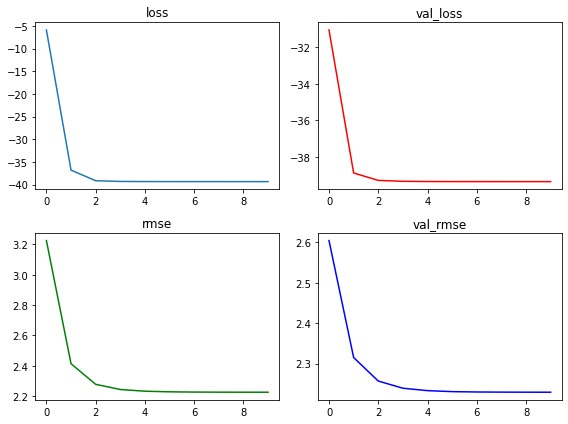

In [40]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

## 2.2 MLP  
  
신경망을 이용한 파트

$\hat{y_{ui}} = \sigma(h^T a(p_u * q_u + W [p_{u_{1,1}}\  q_{u_{2,1}}] + b))$

In [67]:
Embedding_size = 8

class MLP(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(16,activation='elu')
        self.Layer2 = layers.Dense(32,activation='elu')
        self.Layer3 = layers.Dense(16,activation='elu')
        self.Layer4 = layers.Dense(8,activation='elu')
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        #mat = user_vec * movie_vec
        mat = keras.layers.Concatenate()([user_vec, movie_vec])
        x = mat + user_bias + movie_bias

        x = self.Layer1(x)
        x = self.dropout(x)
        x = self.Layer2(x)
        x = self.dropout(x)
        x = self.Layer3(x)
        x = self.dropout(x)

        return self.Layer4(x)



test_model2 = MLP(num_users, num_movies, Embedding_size)
test_model2.compile(loss = keras.losses.MeanAbsoluteError() ,optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['RootMeanSquaredError'])

In [68]:
history2 = test_model2.fit(X_train, y_train,batch_size=128,epochs=100,validation_data=(X_val,y_val),callbacks=[es])

Epoch 1/100
6252/6252 [==============================] - 28s 4ms/step - loss: 0.8240 - root_mean_squared_error: 1.0541 - val_loss: 0.7453 - val_root_mean_squared_error: 0.9290
Epoch 2/100
6252/6252 [==============================] - 28s 4ms/step - loss: 0.7529 - root_mean_squared_error: 0.9438 - val_loss: 0.7319 - val_root_mean_squared_error: 0.9258
Epoch 3/100
6252/6252 [==============================] - 27s 4ms/step - loss: 0.7323 - root_mean_squared_error: 0.9248 - val_loss: 0.7244 - val_root_mean_squared_error: 0.9117
Epoch 4/100
6252/6252 [==============================] - 28s 4ms/step - loss: 0.7199 - root_mean_squared_error: 0.9153 - val_loss: 0.7180 - val_root_mean_squared_error: 0.9145
Epoch 5/100
6252/6252 [==============================] - 28s 5ms/step - loss: 0.7117 - root_mean_squared_error: 0.9118 - val_loss: 0.7086 - val_root_mean_squared_error: 0.9156
Epoch 6/100
6252/6252 [==============================] - 28s 4ms/step - loss: 0.7015 - root_mean_squared_error: 0.9176 -

In [74]:
test_model2.save('/content/drive/MyDrive/datasets/recommender_system/ml-1M/models/MLP.h5py')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/recommender_system/ml-1M/models/MLP.h5py/assets


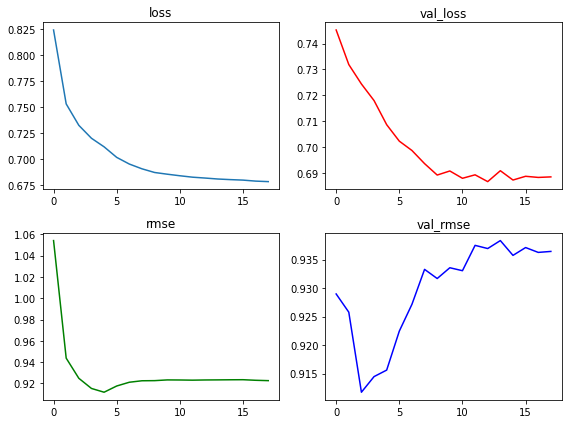

In [71]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history2.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history2.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history2.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history2.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

## 2.3 Neu-MF  
  
Concatenate GMF and MLP parts

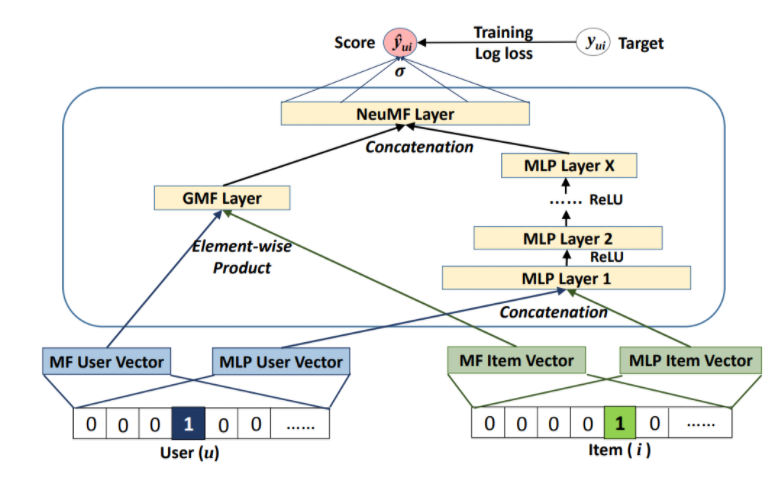

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/datasets/img/recommender/cnf.PNG')

In [78]:
Embedding_size = 8

class Neu_MF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(Neu_MF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(16,activation='elu')
        self.Layer2 = layers.Dense(32,activation='elu')
        self.Layer3 = layers.Dense(16,activation='elu')
        self.Layer4 = layers.Dense(8,activation='elu')
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        
        # GMF

        user_vec_gmf = self.user_embedding(inputs[:,0])
        user_vec_gmf = Reshape(user_vec_gmf, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_gmf = self.user_bias(inputs[:,0])

        movie_vec_gmf = self.movie_embedding(inputs[:,1])
        movie_vec_gmf = Reshape(movie_vec_gmf, shape = (-1, self.embedding_size))
        movie_bias_gmf = self.movie_bias(inputs[:,1])

        #mat_gmf = user_vec_gmf * movie_vec_gmf
        mat_gmf = keras.layers.merge.dot([user_vec_gmf, movie_vec_gmf], axes=1)
        gmf = mat_gmf + user_bias_gmf + movie_bias_gmf

        # MLP

        user_vec_mlp = self.user_embedding(inputs[:,0])
        user_vec_mlp = Reshape(user_vec_mlp, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_mlp = self.user_bias(inputs[:,0])

        movie_vec_mlp = self.movie_embedding(inputs[:,1])
        movie_vec_mlp = Reshape(movie_vec_mlp, shape = (-1, self.embedding_size))
        movie_bias_mlp = self.movie_bias(inputs[:,1])

        # concat in MLP part

        concat_mlp = keras.layers.Concatenate()([user_vec_mlp, movie_vec_mlp])

        # MLP Layers
        x = self.dropout(self.Layer1(concat_mlp))
        x = self.dropout(self.Layer2(x))
        x = self.dropout(self.Layer3(x))
        mlp = x

        # concat MLP n GMF
        x = keras.layers.Concatenate()([gmf, mlp])

        # Final Prediction

        pred = self.Layer4(x)

        return pred

test_model3 = Neu_MF(num_users, num_movies, Embedding_size)
test_model3.compile(loss = keras.losses.MeanAbsoluteError(),optimizer=keras.optimizers.Nadam(lr=1e-3), metrics=['RootMeanSquaredError'])

In [79]:
history3 = test_model3.fit(X_train, y_train,batch_size=128,epochs=100,validation_data=(X_val,y_val),callbacks=[es])

Epoch 1/100
6252/6252 [==============================] - 38s 6ms/step - loss: 0.8104 - root_mean_squared_error: 1.0432 - val_loss: 0.7304 - val_root_mean_squared_error: 0.9250
Epoch 2/100
6252/6252 [==============================] - 38s 6ms/step - loss: 0.7311 - root_mean_squared_error: 0.9291 - val_loss: 0.7173 - val_root_mean_squared_error: 0.9119
Epoch 3/100
6252/6252 [==============================] - 39s 6ms/step - loss: 0.7113 - root_mean_squared_error: 0.9086 - val_loss: 0.7147 - val_root_mean_squared_error: 0.9168
Epoch 4/100
6252/6252 [==============================] - 39s 6ms/step - loss: 0.7014 - root_mean_squared_error: 0.8993 - val_loss: 0.7092 - val_root_mean_squared_error: 0.9054
Epoch 5/100
6252/6252 [==============================] - 39s 6ms/step - loss: 0.6951 - root_mean_squared_error: 0.8937 - val_loss: 0.7072 - val_root_mean_squared_error: 0.9090
Epoch 6/100
6252/6252 [==============================] - 38s 6ms/step - loss: 0.6908 - root_mean_squared_error: 0.8904 -

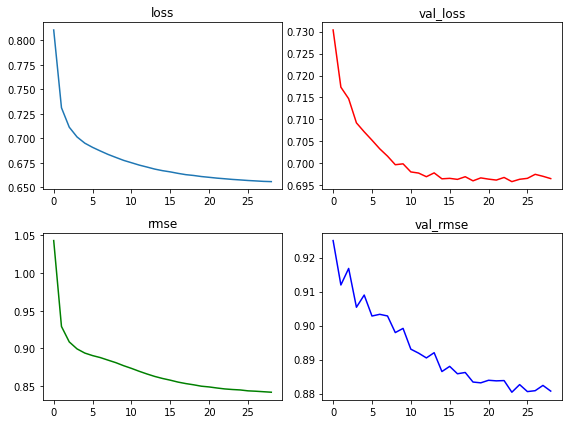

In [80]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history3.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history3.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history3.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history3.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

In [92]:
results = test_model3.evaluate(X_val,y_val, batch_size=128)
print("test loss", round(results[0],4))
print('test rmse',round(results[1],4))

1563/1563 [==============================] - 3s 2ms/step - loss: 0.6965 - root_mean_squared_error: 0.8807
test loss 0.6965
test rmse 0.8807


# Result


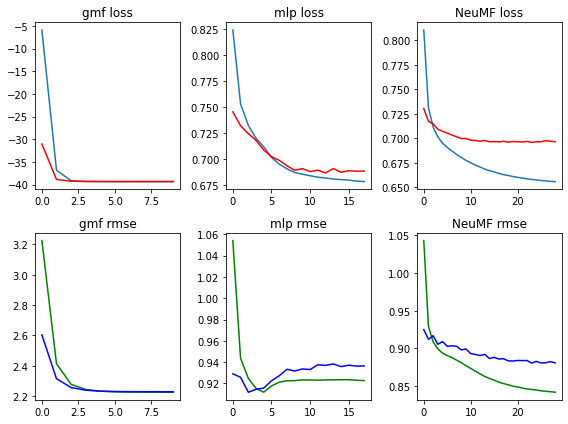

In [84]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(231) # instead of plt.subplot(2, 2, 1)
sub1.set_title('gmf loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'])
sub1.plot(history.history['val_loss'],c='red')

sub2 = fig.add_subplot(234) 
sub2.set_title('gmf rmse')
sub2.plot(history.history['root_mean_squared_error'],c='green')
sub2.plot(history.history['val_root_mean_squared_error'],c='blue')

sub3 = fig.add_subplot(232) # instead of plt.subplot(2, 2, 1)
sub3.set_title('mlp loss') # non OOP: plt.title('The function f')
sub3.plot(history2.history['loss'])
sub3.plot(history2.history['val_loss'],c='red')

sub4 = fig.add_subplot(235) 
sub4.set_title('mlp rmse')
sub4.plot(history2.history['root_mean_squared_error'],c='green')
sub4.plot(history2.history['val_root_mean_squared_error'],c='blue')

sub5 = fig.add_subplot(233) # instead of plt.subplot(2, 2, 1)
sub5.set_title('NeuMF loss') # non OOP: plt.title('The function f')
sub5.plot(history3.history['loss'])
sub5.plot(history3.history['val_loss'],c='red')

sub6 = fig.add_subplot(236) 
sub6.set_title('NeuMF rmse')
sub6.plot(history3.history['root_mean_squared_error'],c='green')
sub6.plot(history3.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

In [87]:
test_model3.save_weights('/content/drive/MyDrive/datasets/recommender_system/ml-1M/models/NeuMF.h5')